## KNN (K-Nearest Neighbors)

KNN is a lazy learning algorithm based on instance based learning, which can be used to solve both regression and classification tasks.

Unlike most ML algorithms, KNN is a lazy-learning model, because KNN models don't train iteratively by itself with predetermined cost functions. In addition, the higher then number of training samples, the larger its model size.

Instead, KNN algorithm computes Euclidean distance between current point and all other points and it determines K points that are nearest to the current point by distance.

<img src = "https://miro.medium.com/max/700/0*34SajbTO2C5Lvigs.png">

Note that if two neighbors have identical distances but different labels, the result will depend on the ordering of the training data.

<b>Assumptions of K-Nearest Neighbors</b>: 
1. Similar data points exist in close proximity, which can be measured by distance metrics
2. Every training data points consists of a set of vectors and class label associated with each vector.

<b>Requirement of feature scaling: Yes</b>

<b>Robust to outliers: No</b>

<b>Is multicollinearity an issue?: No</b>

<b>Advantages of KNN</b>:
- Simple and easy algorithm to implement
- No requirement to train model, so that data points can be added easily 
- No strict assumptions, since it is a non-parametric algorithm

<b>Disadvantages of KNN</b>: 
- Algorithm is significantly slower as number of training examples/predictors increases, since more memory is required during model evaluation
- Not robust to outliers and less suitable for larger datasets
- Less suitable for regression tasks

<b>Methods to handle imbalanced dataset</b>:
1. Resampling techniques (Oversampling/SMOTETomek)

## KNN algorithms

In KNN, there are three types of algorithms available:

1. <b>brute-force</b>: Euclidean distance from point of interest to all the points in training set are computed. Then, from a set of K neighbors, either the class with majority points is selected or the average of set of K neighbors is used instead.

- <b>Time complexity of model training: O(1)</b>

- <b>Time complexity of model prediction: O(knd)</b>

- <b>Space complexity of model prediction: O(knd)</b>

- n - Number of training samples

- k - Number of neighbors

- d - Number of features

Note that brute-force approach is less suitable for datasets with large sample size.

2. <b>k-d tree</b>: Hierarchical binary tree that rearranges the whole dataset in a binary tree by dividing the dataset by median values.

<img src = "https://miro.medium.com/max/700/0*aq6fJrS1QfR_du19.png" width="400">

- <b>Time complexity of model training: O(1)</b>

- <b>Time complexity of model prediction (Best to worst case): O(2^d*(k)*log n) to O(k*n)</b>

- <b>Space complexity of model prediction: O(k*n)</b>

- n - Number of training samples

- k - Number of neighbors

- d - Number of features

Note that k-d tree approach is less suitable for high-dimensional datasets.

3. <b>ball tree</b>: Hierarchical ball tree that groups points into clusters organized in a tree structure.

<img src = "https://miro.medium.com/max/700/0*e7VoxNaB_BSd8fFP.png" width="500">

<img src = "https://miro.medium.com/max/502/0*NJ4ARL6vl73J8hJJ.png" width="400">

Note that ball tree approach performs well for high-dimensional datasets, but at a higher time complexity cost

## Selection of leaf_size

While brute-force approach is more efficient than tree-based query for small sample size, ball tree and K-D tree approach internally switches to brute-force approach within leaf nodes based on leaf_size hyperparameter.

Setting values for leaf_size hyperparameter has the following impacts:
1. construction time: Larger leaf_size leads to faster tree construction time, since less nodes need to be created.
2. query time: Very small leaf_size signficantly increases query time, while very large leaf_size leads to brute-fore appraoch. A good compromise between these is leaf_size = 30, which is the default value.
3. memory: Larger leaf size leads to less memory required to store tree structure.

## Selection of K-value

Selecting the optimum K value for the KNN algorithm requires hyperparameter tuning to identify the best K value that provides the best model performance.

General guidelines on selection of K values:
1. Odd number of K value is preferable in the case of tiebreaker when taking a majority vote in classification problem. However, sklearn breaks tie values based on closest distance to point of interest

2. Increasing K value might result in more stable model predictions up to a certain point.

Note that larger K values might indicate high bias (underfitting), while smaller K values might indicate high variance (overfitting)

## Distance Calculation in KNN

KNN algorithm computes the distance between point of interest and all other points using one of the following popular methods with its respective distance function:

1. <b>Euclidean Distance</b>

![image](https://www.researchgate.net/profile/Arya-Paryani/publication/360358579/figure/fig1/AS%3A1175120408260610%401657181946277/2-Euclidean-Distance-Formula-523-Determine-if-eyes-are-blinking.png)

2. <b>Manhattan Distance</b>

![image](https://miro.medium.com/max/1018/1%2AKDgfdK6SooXtaUvlnXdpaA.png)

3. <b>Hamming Distance</b>

![image](https://www.saedsayad.com/images/KNN_hamming.png)

<b>Note than euclidean and manhattan distance are used for continuous variables, while hamming distance is used for categorical variables</b>. 

<b>Manhattan distance is preferred over euclidean distance for higher data dimensionality</b>.

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_wine
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from transformers import OutlierCapTransformer, ScalingTransformer

More details related to Exploratory Data Analysis for both regression and classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Regression.ipynb and EDA_Classification.ipynb

## KNN for regression

<b>Important hyperparameters for KNeighborsRegressor</b>:
1. n_neighbors: Number of neighbors to use
2. weights: Weight function used in prediction (uniform - equal weights for all points vs distance - closer points have higher weights)
3. leaf_size: Leaf size passed to Ball tree or K-D tree.

In [2]:
data = fetch_california_housing()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Median House Value ($100000)'

In [3]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = KFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_rmse, test_rmse = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        if search_space != None:
            search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,
                                   scoring= make_scorer(mean_squared_error, squared=False),refit=True, n_jobs=3)
            search.fit(X_train,y_train)
            val_rmse.append(search.best_score_)
            print(f'Validation RMSE for fold {fold+1}:',search.best_score_)
            print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
            y_pred = search.best_estimator_.predict(X_test)
        else:
            cv_results = cross_validate(pipeline, X_train, y_train, scoring = {'rmse': make_scorer(mean_squared_error, squared=False)}, cv=3, n_jobs=3)
            val_rmse.append(cv_results['test_rmse'].mean())
            print(f'Validation RMSE for fold {fold+1}:', cv_results['test_rmse'].mean())
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
        test_rmse.append(mean_squared_error(y_test,y_pred,squared=False))
        print(f'Test RMSE for fold {fold+1}:',mean_squared_error(y_test,y_pred,squared=False))
    print('----------------------')
    print('Average validation RMSE score:', np.mean(val_rmse))
    print('Average test RMSE score:', np.mean(test_rmse))

In [4]:
reg = KNeighborsRegressor(n_jobs=3)
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Robust')))
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__n_neighbors'] = Categorical([1,3,5,7])
search_space['regression__weights'] = Categorical(['uniform','distance'])
search_space['regression__leaf_size'] = Integer(20,40)
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 0.7690469439772308
Best hyperparameters for fold 1: OrderedDict([('regression__leaf_size', 39), ('regression__n_neighbors', 3), ('regression__weights', 'uniform')])
Test RMSE for fold 1: 0.6601987942808768
Validation RMSE for fold 2: 0.764491224247887
Best hyperparameters for fold 2: OrderedDict([('regression__leaf_size', 30), ('regression__n_neighbors', 3), ('regression__weights', 'uniform')])
Test RMSE for fold 2: 0.6738583902002209
Validation RMSE for fold 3: 0.7658621169818479
Best hyperparameters for fold 3: OrderedDict([('regression__leaf_size', 28), ('regression__n_neighbors', 3), ('regression__weights', 'uniform')])
Test RMSE for fold 3: 0.67746334686579
Validation RMSE for fold 4: 0.9066608363448673
Best hyperparameters for fold 4: OrderedDict([('regression__leaf_size', 23), ('regression__n_neighbors', 1), ('regression__weights', 'distance')])
Test RMSE for fold 4: 0.8114779266741398
Validation RMSE for fold 5: 0.9110617872074804
Best hyperparameter

## KNN for classification

<b>Important hyperparameters for KNeighborsClassifier</b>:
1. n_neighbors: Number of neighbors to use
2. weights: Weight function used in prediction (uniform - equal weights for all points vs distance - closer points have higher weights)
3. leaf_size: Leaf size passed to Ball tree or K-D tree.

In [5]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Wine_Class'

In [6]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

In [7]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - KNeighborsClassifier (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.9379282858433035
Best hyperparameters for fold 1: OrderedDict([('classification__leaf_size', 28), ('classification__n_neighbors', 7), ('classification__weights', 'distance')])
Test F1 score for fold 1: 1.0



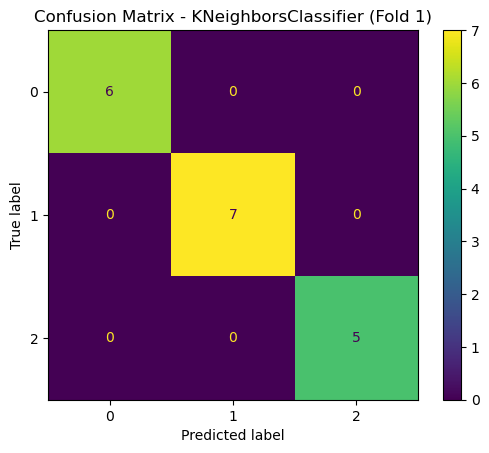


Validation F1 score for fold 2: 0.9457205816473551
Best hyperparameters for fold 2: OrderedDict([('classification__leaf_size', 40), ('classification__n_neighbors', 7), ('classification__weights', 'uniform')])
Test F1 score for fold 2: 1.0



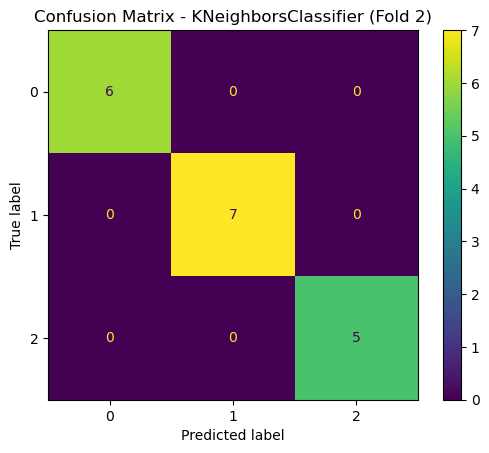


Validation F1 score for fold 3: 0.9499890093105868
Best hyperparameters for fold 3: OrderedDict([('classification__leaf_size', 37), ('classification__n_neighbors', 1), ('classification__weights', 'distance')])
Test F1 score for fold 3: 0.8968253968253967



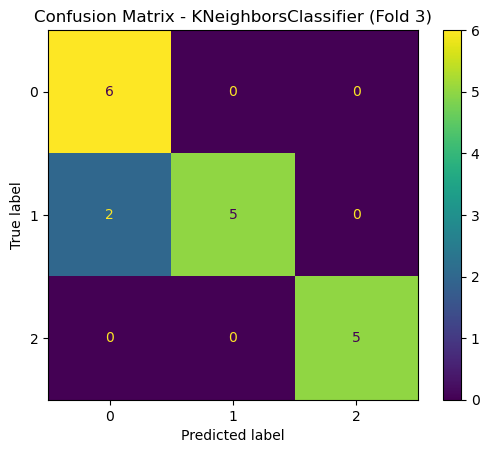


Validation F1 score for fold 4: 0.958134325713273
Best hyperparameters for fold 4: OrderedDict([('classification__leaf_size', 30), ('classification__n_neighbors', 7), ('classification__weights', 'uniform')])
Test F1 score for fold 4: 1.0



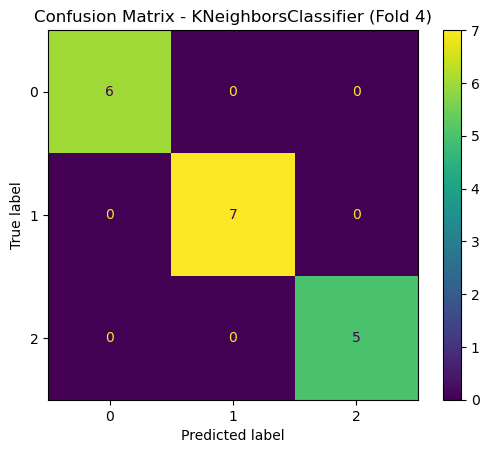


Validation F1 score for fold 5: 0.9457802551018327
Best hyperparameters for fold 5: OrderedDict([('classification__leaf_size', 32), ('classification__n_neighbors', 5), ('classification__weights', 'uniform')])
Test F1 score for fold 5: 1.0



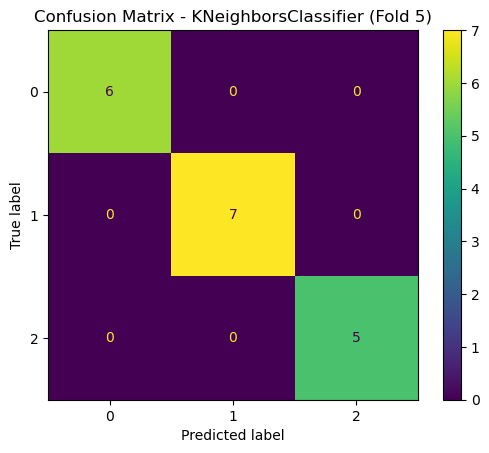


Validation F1 score for fold 6: 0.9572796726114803
Best hyperparameters for fold 6: OrderedDict([('classification__leaf_size', 25), ('classification__n_neighbors', 1), ('classification__weights', 'distance')])
Test F1 score for fold 6: 0.9487179487179486



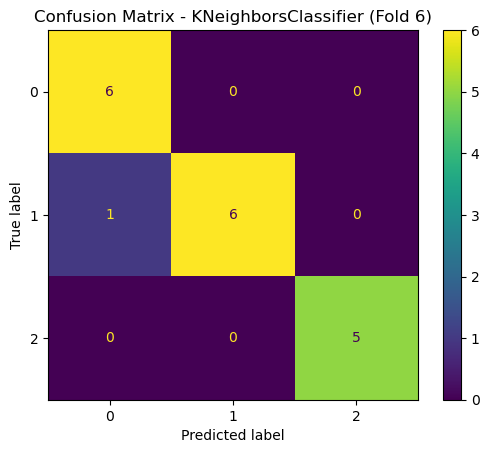


Validation F1 score for fold 7: 0.9496358714347677
Best hyperparameters for fold 7: OrderedDict([('classification__leaf_size', 39), ('classification__n_neighbors', 3), ('classification__weights', 'distance')])
Test F1 score for fold 7: 1.0



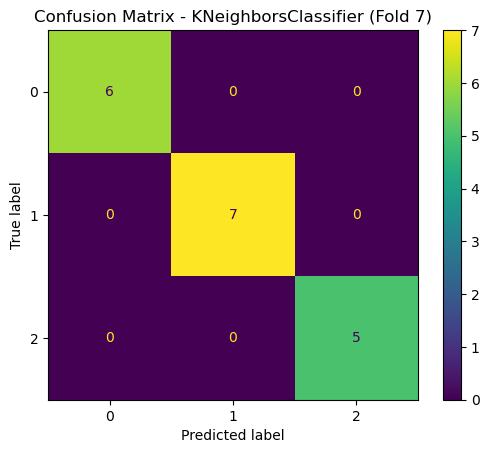


Validation F1 score for fold 8: 0.9648970523650829
Best hyperparameters for fold 8: OrderedDict([('classification__leaf_size', 29), ('classification__n_neighbors', 1), ('classification__weights', 'uniform')])
Test F1 score for fold 8: 0.8888888888888888



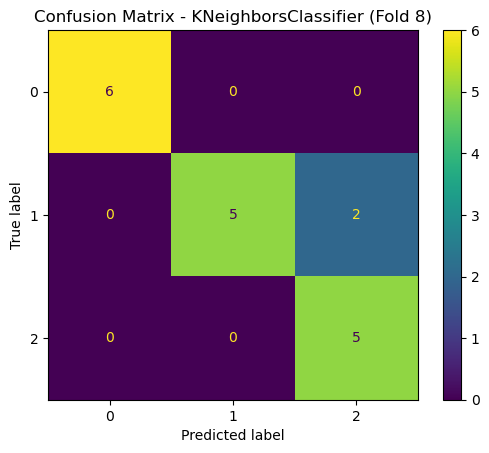


Validation F1 score for fold 9: 0.9458504055915101
Best hyperparameters for fold 9: OrderedDict([('classification__leaf_size', 33), ('classification__n_neighbors', 7), ('classification__weights', 'uniform')])
Test F1 score for fold 9: 1.0



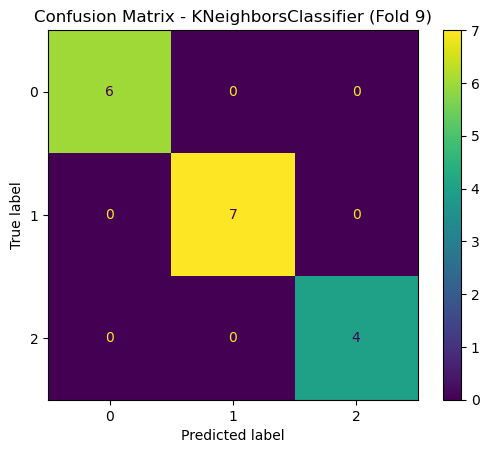


Validation F1 score for fold 10: 0.9519237751823564
Best hyperparameters for fold 10: OrderedDict([('classification__leaf_size', 23), ('classification__n_neighbors', 5), ('classification__weights', 'uniform')])
Test F1 score for fold 10: 0.9407407407407408



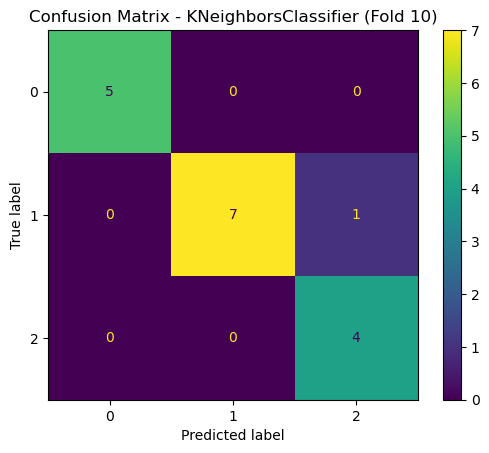


----------------------
Average validation F1 score: 0.9507139234801549
Average test F1 score: 0.9675172975172975


In [8]:
clf = KNeighborsClassifier(n_jobs=3)
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Robust')))
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__n_neighbors'] = Categorical([1,3,5,7])
search_space['classification__weights'] = Categorical(['uniform','distance'])
search_space['classification__leaf_size'] = Integer(20,40)
nested_cv(X, y, pipeline, search_space)

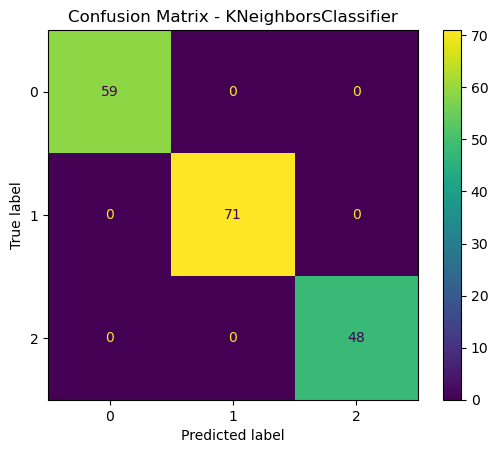

In [9]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - KNeighborsClassifier")
plt.grid(False)
plt.show()